# Proyecto 2: Análisis Exploratorio
### Tema 12: Google - American Sign Language Fingerspelling Recognition
<div align="center">
<img src=./data/image.png alt="Sign Language Fingerspelling Recognition" width="600"/>
</div>

**Integrantes:**
- Derek Fabian Arreaga Kelson | 22537
- Mónica Alejandra Salvatierra Chacón | 22249
- Sofía Mishell Velásquez Mérida | 22049
- Paula Rebeca Barillas Alvarez | 22764

## Librerías principales para análisis de datos y visualización

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import json
from collections import Counter
from pathlib import Path
from scipy.stats import chi2_contingency, kruskal, f_oneway
import warnings
warnings.filterwarnings('ignore')

## Lectura de los datos principales

In [10]:
train = pd.read_csv('./data/train.csv')
metadata = pd.read_csv('./data/supplemental_metadata.csv')
import json
with open('./data/character_to_prediction_index.json', 'r') as f:
    char_map = json.load(f)

## Tipo de datos del dataset

In [11]:
print('Dimensiones del dataset:', train.shape)
print('\nTipos de datos:')
print(train.dtypes)
print('\nPrimeras filas:')
display(train.head())

Dimensiones del dataset: (67208, 5)

Tipos de datos:
path              object
file_id            int64
sequence_id        int64
participant_id     int64
phrase            object
dtype: object

Primeras filas:


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


## Variables numéricas

In [12]:
# variables numéricas
train.describe().T

,count,mean,std,min,25%,50%,75%,max
file_id,67208.0,1.094448e+09,6.395616e+08,5414471.0,5.277082e+08,1.099408e+09,1.662743e+09,2.118949e+09
sequence_id,67208.0,1.072696e+09,6.177372e+08,71095.0,5.376519e+08,1.074387e+09,1.605592e+09,2.147465e+09
participant_id,67208.0,1.197582e+02,7.433047e+01,0.0,6.300000e+01,1.130000e+02,1.780000e+02,2.540000e+02


### Distribución de variables númericas

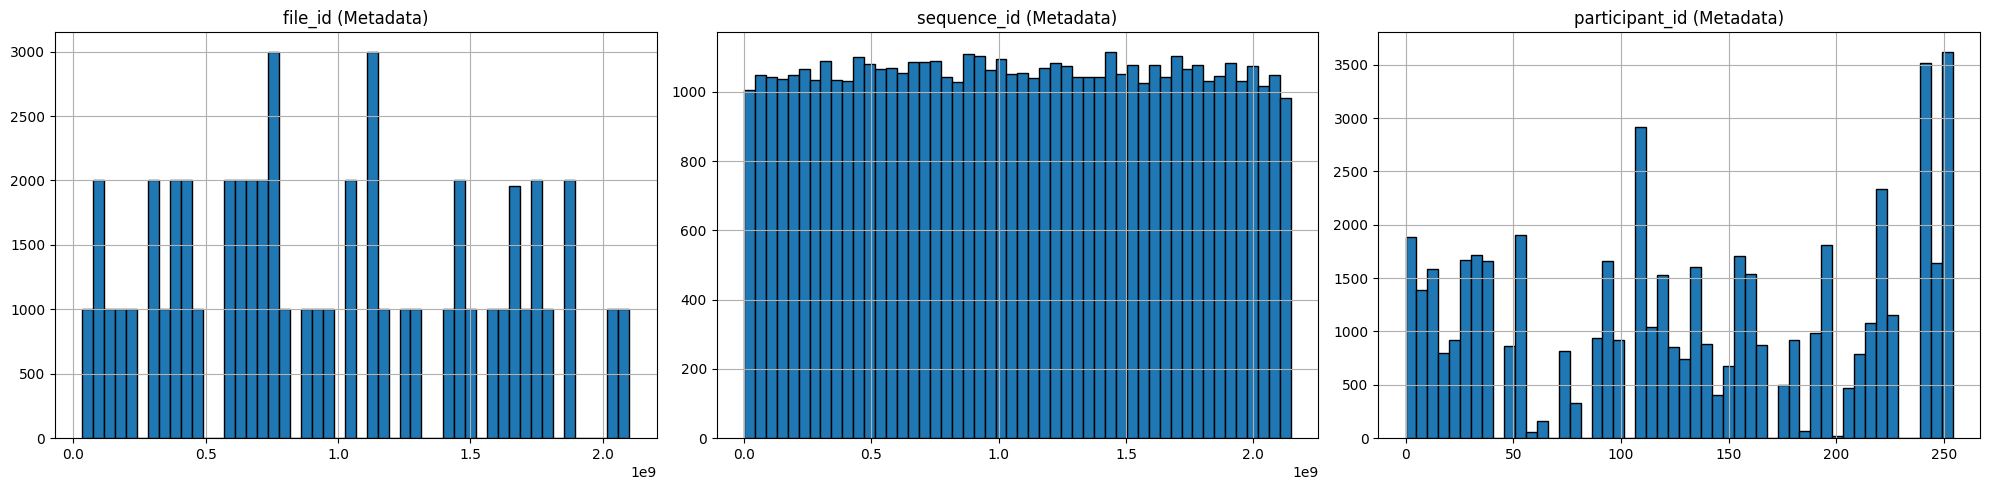

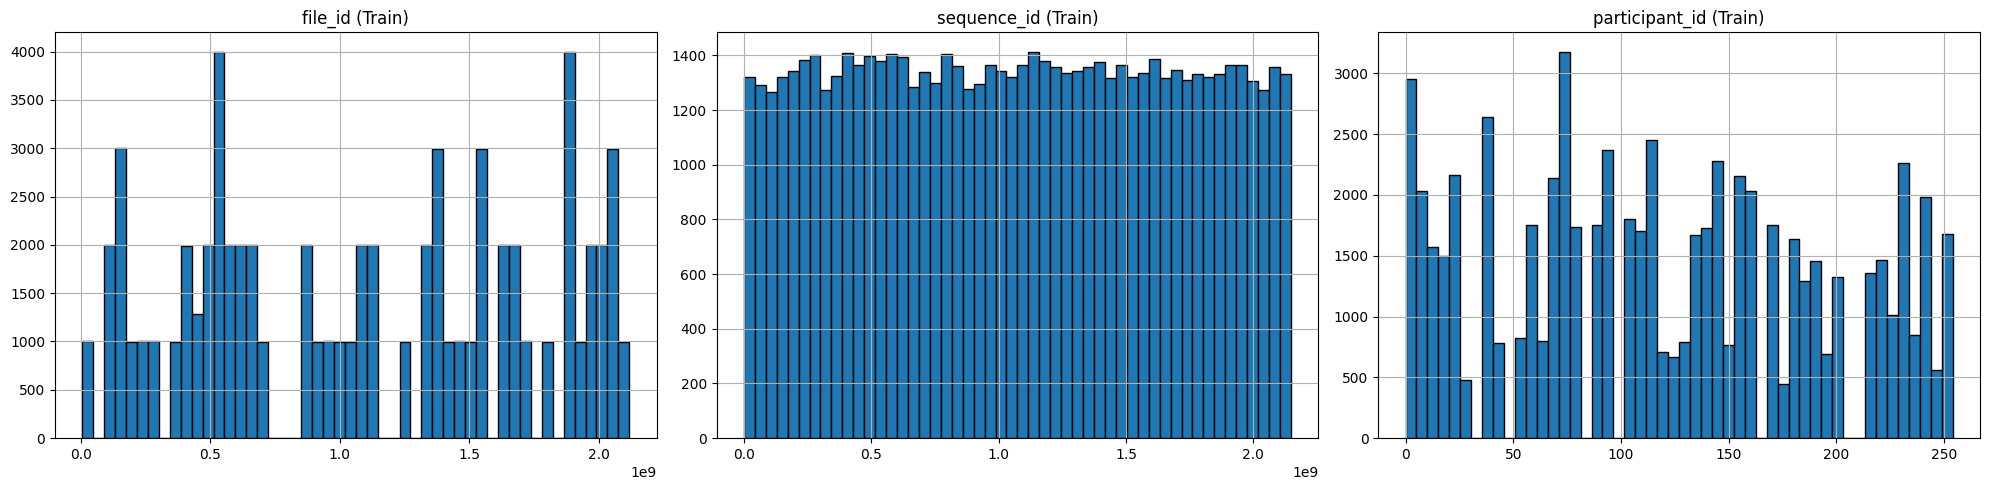

In [13]:
num_cols = ['file_id', 'sequence_id', 'participant_id']
metadata_numeric = metadata[num_cols]
train_numeric = train[num_cols]
def graficar_histogramas(df_numeric, titulo_dataset):
    cols = 3
    rows = (len(df_numeric.columns) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(df_numeric.columns):
        df_numeric[col].hist(ax=axes[i], bins=50, edgecolor="black")
        axes[i].set_title(f"{col} ({titulo_dataset})")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_histogramas(metadata_numeric, "Metadata")
graficar_histogramas(train_numeric, "Train")

## Análisis de variables categóricas

### Tablas de frecuencia para variables categóricas

In [14]:
cat_cols = ['participant_id', 'file_id', 'sequence_id', 'phrase']
for col in cat_cols:
    print(f'\nFrecuencia de valores en {col}:')
    print(train[col].value_counts().head(10))


Frecuencia de valores en participant_id:
participant_id
36     1535
105    1006
112     953
81      944
89      896
188     895
56      890
178     886
141     886
2       885
Name: count, dtype: int64

Frecuencia de valores en file_id:
file_id
5414471      1000
105143404    1000
128822441    1000
149822653    1000
152029243    1000
234418913    1000
296317215    1000
433948159    1000
522550314    1000
527708222    1000
Name: count, dtype: int64

Frecuencia de valores en sequence_id:
sequence_id
388332538     1
1816796431    1
1816825349    1
1816909464    1
1816967051    1
1817123330    1
1817141095    1
1817169529    1
387524930     1
387496458     1
Name: count, dtype: int64

Frecuencia de valores en phrase:
phrase
surprise az                        17
yonkers new york                   16
fort worth tx                      16
raleigh north carolina             15
buffalo ny                         14
north charleston south carolina    13
alexandria virginia                13
over

In [15]:
# Feature engineering sobre 'phrase'
def phrase_type(s: str) -> str:
    if pd.isna(s) or s == "":
        return "NA"
    s2 = str(s)
    if re.search(r"(http|www\.)", s2, flags=re.I):
        return "url"
    if re.search(r"\d{3}[-\s.]?\d{3}[-\s.]?\d{4}", s2):           
        return "phone_like"
    if re.search(r"\d", s2) and re.search(r"[A-Za-z]", s2) and re.search(r"\b(st|ave|rd|blvd|dr|ln|lane|road)\b", s2, flags=re.I):
        return "address_like"
    if re.fullmatch(r"[A-Za-z]+(?:\s+[A-Za-z]+)*", s2):
        return "word"
    return "mixed"

train["phrase_len"] = train["phrase"].astype(str).str.len()
train["num_alpha"]  = train["phrase"].fillna("").apply(lambda x: sum(ch.isalpha() for ch in str(x)))
train["num_digits"] = train["phrase"].fillna("").apply(lambda x: sum(ch.isdigit() for ch in str(x)))
train["num_symbols"]= train["phrase"].fillna("").apply(lambda x: sum(not ch.isalnum() and not ch.isspace() for ch in str(x)))
train["phrase_type"]= train["phrase"].apply(phrase_type)

bins = [0,5,10,20,40,1_000]
labels = ["0-5","6-10","11-20","21-40",">40"]
train["len_bin"] = pd.cut(train["phrase_len"], bins=bins, labels=labels, right=True, include_lowest=True)

# Resumen de variables categóricas
cat_cols = ["participant_id", "file_id", "phrase_type", "len_bin", "phrase"]
for c in cat_cols:
    if c in train:
        print(f"\n>>> {c} <<<")
        print(train[c].value_counts().head(10))
        print("Niveles únicos:", train[c].nunique())


>>> participant_id <<<
participant_id
36     1535
105    1006
112     953
81      944
89      896
188     895
56      890
178     886
141     886
2       885
Name: count, dtype: int64
Niveles únicos: 94

>>> file_id <<<
file_id
5414471      1000
105143404    1000
128822441    1000
149822653    1000
152029243    1000
234418913    1000
296317215    1000
433948159    1000
522550314    1000
527708222    1000
Name: count, dtype: int64
Niveles únicos: 68

>>> phrase_type <<<
phrase_type
mixed           37965
phone_like       8746
word             8347
url              7074
address_like     5076
Name: count, dtype: int64
Niveles únicos: 5

>>> len_bin <<<
len_bin
11-20    42446
21-40    21771
6-10      2892
0-5         99
>40          0
Name: count, dtype: int64
Niveles únicos: 4

>>> phrase <<<
phrase
surprise az                        17
yonkers new york                   16
fort worth tx                      16
raleigh north carolina             15
buffalo ny                         14
no

### Tablas de contingencia

In [16]:
if "len_bin" in train and "phrase_type" in train:
    ct = pd.crosstab(train["len_bin"], train["phrase_type"])
    print("\nTabla len_bin x phrase_type:\n", ct)
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi²={chi2:.2f}, p={p:.4g}, dof={dof}")


Tabla len_bin x phrase_type:
 phrase_type  address_like  mixed  phone_like   url  word
len_bin                                                 
0-5                     0     79           0     0    20
6-10                    2   1852           4     8  1026
11-20                2781  21826        8463  2145  7231
21-40                2293  14208         279  4921    70
Chi²=14371.08, p=0, dof=12


### Gráficos Exploratorios

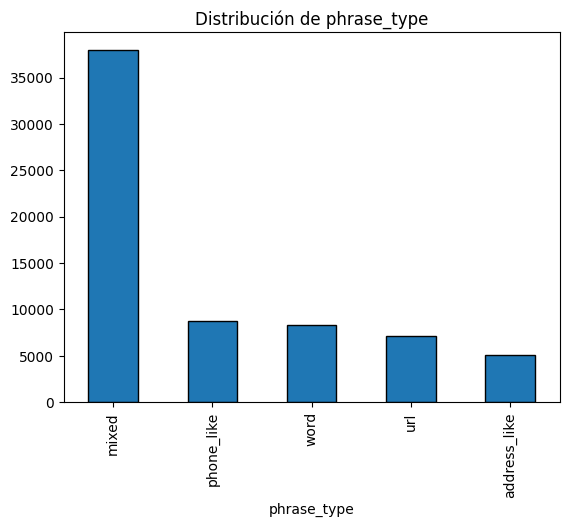

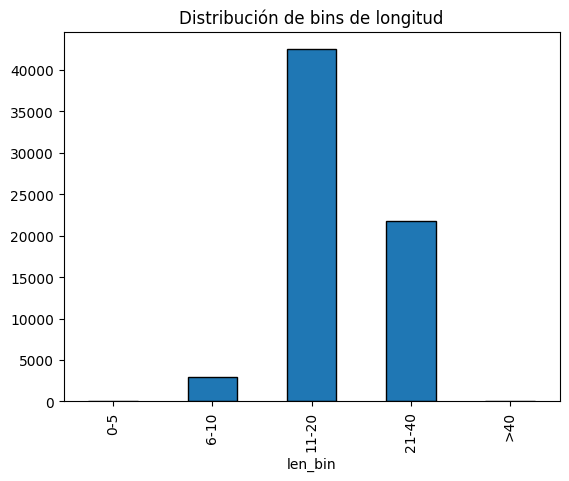

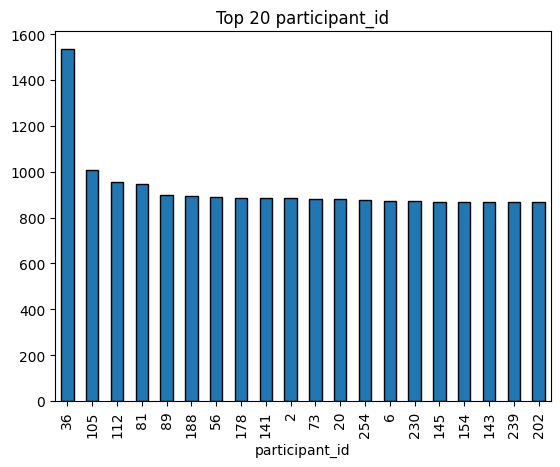

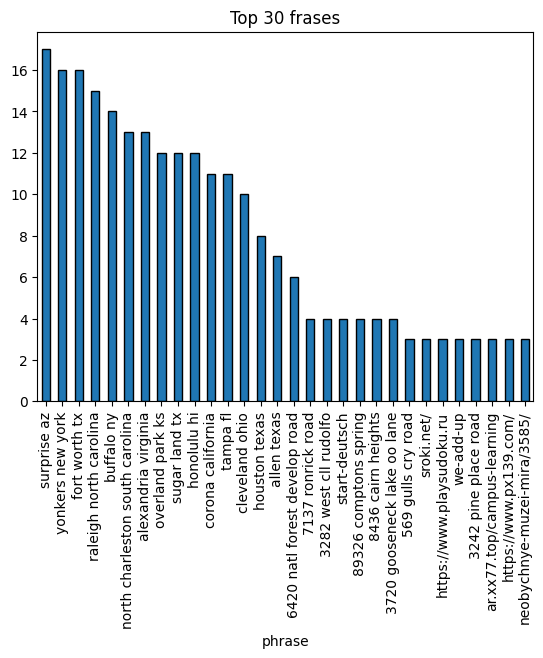

In [17]:
# Distribución de phrase_type
train["phrase_type"].value_counts().plot(kind="bar", edgecolor="black", title="Distribución de phrase_type")
plt.show()

# Distribución de len_bin
train["len_bin"].value_counts().sort_index().plot(kind="bar", edgecolor="black", title="Distribución de bins de longitud")
plt.show()

# Top-20 participant_id
train["participant_id"].value_counts().head(20).plot(kind="bar", edgecolor="black", title="Top 20 participant_id")
plt.show()

# Top-30 frases
train["phrase"].value_counts().head(30).plot(kind="bar", edgecolor="black", title="Top 30 frases", rot=90)
plt.show()


### Distribución de Caracteres en Phrases

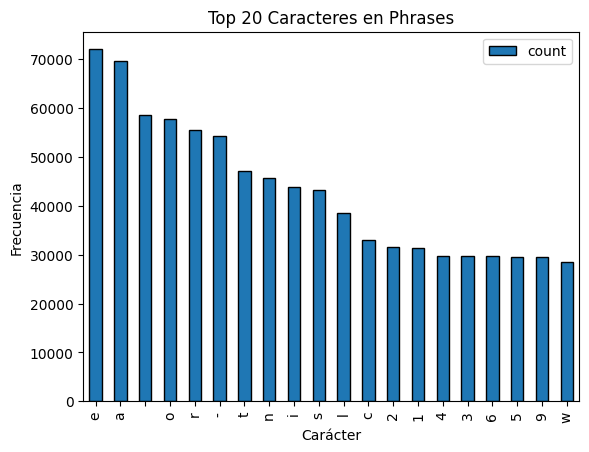


Top-5 caracteres en mixed:
e    45432
a    40961
     36008
-    34242
o    33828
dtype: int64

Top-5 caracteres en address_like:
     14767
a     7606
r     7292
o     6469
e     6427
dtype: int64

Top-5 caracteres en url:
w    19411
.    14569
o    10867
t     9307
e     9193
dtype: int64

Top-5 caracteres en phone_like:
-    18587
6     9320
1     9267
5     9220
9     9197
dtype: int64

Top-5 caracteres en word:
a    11770
e    10917
n     9039
r     8892
      7759
dtype: int64


In [ ]:
# Contar caracteres en todas las frases
all_chars = ''.join(train['phrase'].astype(str))
char_counts = Counter(all_chars)
char_df = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count']).sort_values('count', ascending=False)

char_df.head(20).plot(kind='bar', edgecolor='black', title='Top 20 Caracteres en Phrases')
plt.xlabel('Carácter'); plt.ylabel('Frecuencia')
plt.show()

for ptype in train['phrase_type'].unique():
    chars = ''.join(train[train['phrase_type'] == ptype]['phrase'].astype(str))
    char_counts = Counter(chars)
    print(f'\nTop-5 caracteres en {ptype}:')
    print(pd.Series(char_counts).nlargest(5))

**Resultados del análisis de caracteres**:
- **Mixed**: Los caracteres más frecuentes son vocales (`e`, `a`, `o`), espacios y guiones (`-`), reflejando la combinación de letras, números y símbolos en frases mixtas. Esto sugiere una alta diversidad en este tipo, lo que puede requerir un modelado robusto para capturar patrones variados.
- **Address_like**: Predominan espacios y letras (`a`, `r`, `o`, `e`), consistentes con términos de direcciones (como por ejemplo "street" o "road"). Los espacios reflejan la estructura de múltiples palabras.
- **Url**: Dominan `w` (por "www") y `.` (puntos en dominios), con vocales (`o`, `e`) y `t`, típicos de URLs sintéticas, Esto indica una estructura predecible.
- **Phone_like**: Los guiones (`-`) y dígitos (`6`, `1`, `5`, `9`) son los más comunes, alineándose con el formato de números telefónicos. La uniformidad de dígitos sugiere facilidad para modelar este tipo.
- **Word**: Predominan vocales (`a`, `e`) y consonantes (`n`, `r`), con espacios, reflejando frases puramente alfabéticas. La ausencia de dígitos valida la definición de `word`.
- **Implicaciones**: La distribución de caracteres varía significativamente por `phrase_type`, lo que sugiere que features basadas en conteos de caracteres pueden mejorar la clasificación inicial de tipos de frases antes del modelado. Además, la alta frecuencia de ciertos caracteres como vocales y guiones, indica que el modelo debe priorizar estas clases en la predicción.

### Comparación Train vs. Supplemental Metadata

In [ ]:
# Aquí

## Cruces entre variables clave

### Longitud y tipo se asocian?

phrase_type  address_like  mixed  phone_like   url  word
len_bin                                                 
0-5                     0     79           0     0    20
6-10                    2   1852           4     8  1026
11-20                2781  21826        8463  2145  7231
21-40                2293  14208         279  4921    70
Chi²=14371.08, dof=12, p=0.00e+00, Cramér's V=0.267


<Figure size 640x480 with 0 Axes>

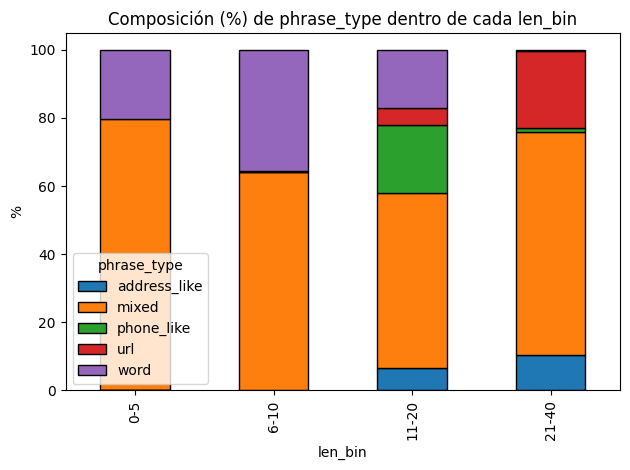

In [18]:
# Tabla de contingencia
ct_lb_pt = pd.crosstab(train["len_bin"], train["phrase_type"])
print(ct_lb_pt)

# Chi² + tamaño de efecto (Cramér's V)
def cramers_v(ct: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape
    return np.sqrt((chi2/n) / (min(r-1, k-1) if min(r-1,k-1)>0 else 1))

chi2, p, dof, _ = chi2_contingency(ct_lb_pt)
print(f"Chi²={chi2:.2f}, dof={dof}, p={p:.2e}, Cramér's V={cramers_v(ct_lb_pt):.3f}")

# Barras apiladas (% por fila)
ct_lb_pt_pct = ct_lb_pt.div(ct_lb_pt.sum(axis=1), axis=0) * 100
plt.figure()
ct_lb_pt_pct.plot(kind="bar", stacked=True, edgecolor="black")
plt.title("Composición (%) de phrase_type dentro de cada len_bin")
plt.xlabel("len_bin"); plt.ylabel("%")
plt.tight_layout(); plt.show()

χ² = 14,371.08; p < 0.001; Cramér’s V = 0.267 → asociación moderada.

Patrones que explican la asociación:
  - Bins largos (21–40): sobre-representación de url y sub-representación de word.
  - Bins medios (11–20): sobre-representación de phone_like, este tipo aparece casi exclusivamente aquí.
  - Bins cortos (0–10): mayor proporción de word (frases cortas puramente alfabéticas).

### Sesgo de usuario

phrase_type  address_like  mixed  phone_like   url  word
part_bucket                                             
Q1                    639   5205        1590   961  1403
Q2                   1235   9350        2011  1752  1984
Q3                   1454  10968        2382  2046  2277
Q4                   1748  12442        2763  2315  2683
Chi²=174.48, dof=12, p=5.79e-31, Cramér's V=0.029


<Figure size 640x480 with 0 Axes>

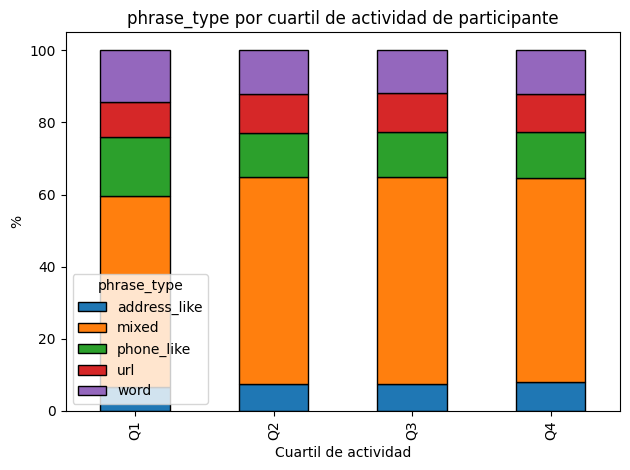

In [19]:
# Bucketiza participantes por actividad (cuartiles según numero de filas por participante)
part_freq = train["participant_id"].value_counts()
part_bucket = pd.qcut(part_freq.rank(method="first")/len(part_freq), q=4, labels=["Q1","Q2","Q3","Q4"])
train_pb = train.merge(part_bucket.to_frame("part_bucket"), left_on="participant_id", right_index=True, how="left")

ct_pb_pt = pd.crosstab(train_pb["part_bucket"], train_pb["phrase_type"])
print(ct_pb_pt)

chi2, p, dof, _ = chi2_contingency(ct_pb_pt)
print(f"Chi²={chi2:.2f}, dof={dof}, p={p:.2e}, Cramér's V={cramers_v(ct_pb_pt):.3f}")

# Barras apiladas (%)
ct_pb_pt_pct = ct_pb_pt.div(ct_pb_pt.sum(axis=1), axis=0) * 100
plt.figure()
ct_pb_pt_pct.plot(kind="bar", stacked=True, edgecolor="black")
plt.title("phrase_type por cuartil de actividad de participante")
plt.xlabel("Cuartil de actividad"); plt.ylabel("%")
plt.tight_layout(); plt.show()


### ¿qué celdas explican la asociación?

Celdas significativas (|z|>2) en len_bin x phrase_type:
phrase_type  address_like      mixed  phone_like        url       word
len_bin                                                               
0-5             -2.734437   3.085767   -3.589317  -3.228045   2.197225
6-10           -14.643825   5.402068  -19.193438 -16.988486  35.184966
11-20           -7.502798 -13.892788   39.549439 -34.749346  26.986084
21-40           15.997774  17.221551  -47.985495  54.930010 -50.652687


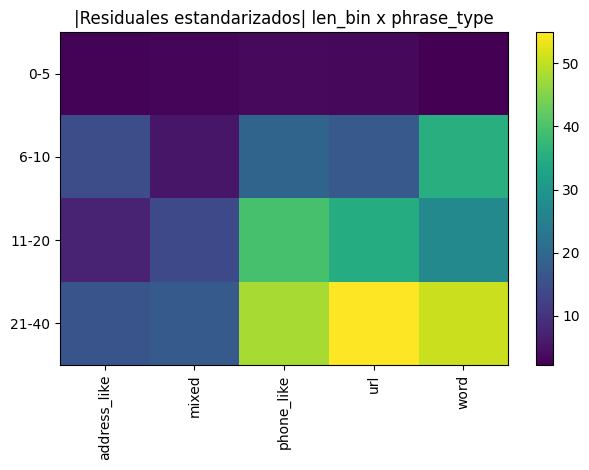

In [20]:
def standardized_residuals(ct: pd.DataFrame) -> pd.DataFrame:
    chi2, p, dof, expected = chi2_contingency(ct)
    obs = ct.values
    res = (obs - expected) / np.sqrt(expected + 1e-12)
    return pd.DataFrame(res, index=ct.index, columns=ct.columns)

res_lb_pt = standardized_residuals(ct_lb_pt)
# Celdas con |z| > 2 son contribuyentes relevantes
sig_cells = (res_lb_pt.abs() > 2)
print("Celdas significativas (|z|>2) en len_bin x phrase_type:")
print(res_lb_pt.where(sig_cells).dropna(how="all").dropna(axis=1, how="all"))

# Visual rápido (heatmap por |z|)
plt.figure()
plt.imshow(res_lb_pt.abs().values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(res_lb_pt.columns)), res_lb_pt.columns, rotation=90)
plt.yticks(range(len(res_lb_pt.index)), res_lb_pt.index)
plt.title("|Residuales estandarizados| len_bin x phrase_type")
plt.tight_layout(); plt.show()


### phrase_len por phrase_type

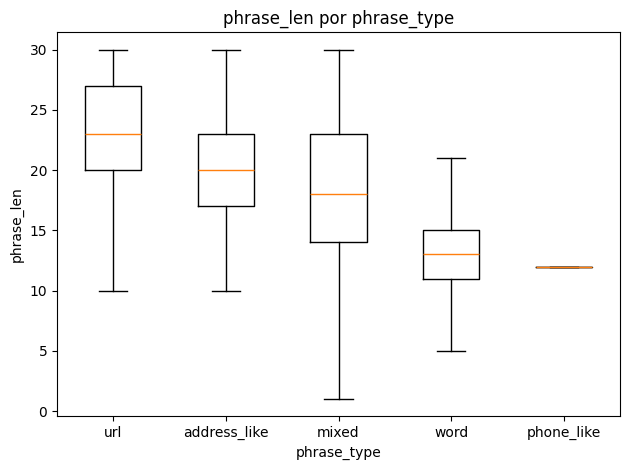

Kruskal-Wallis phrase_len ~ phrase_type: H=22906.90, p=0.00e+00


In [21]:
# Boxplot sin outliers para legibilidad
order = train.groupby("phrase_type")["phrase_len"].median().sort_values(ascending=False).index
data = [train.loc[train["phrase_type"]==t, "phrase_len"].dropna().values for t in order]

plt.figure()
plt.boxplot(data, labels=list(order), showfliers=False)
plt.title("phrase_len por phrase_type")
plt.xlabel("phrase_type"); plt.ylabel("phrase_len")
plt.tight_layout(); plt.show()

# Prueba no paramétrica (Kruskal-Wallis)
stat, p = kruskal(*data)
print(f"Kruskal-Wallis phrase_len ~ phrase_type: H={stat:.2f}, p={p:.2e}")


- Kruskal-Wallis H = 22,906.90; p < 0.001: distribuciones distintas.
- Orden de medianas:
  - 1. url
  - 2. address_like
  - 3. mixed
  - 4. word
  - 5. phone_like
- Las características de longitud y conteos (num_digits, num_symbols) diferencian bien a los tipos.

### Numérico dentro de categorías

mixed         pendiente≈-0.124  intercepción≈6.97


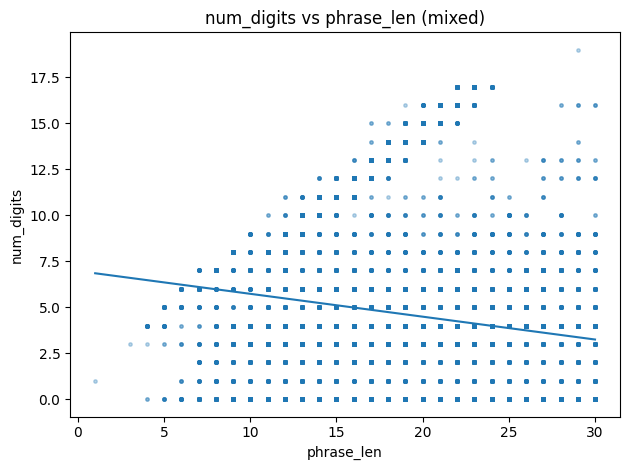

phone_like    pendiente≈0.609  intercepción≈2.69


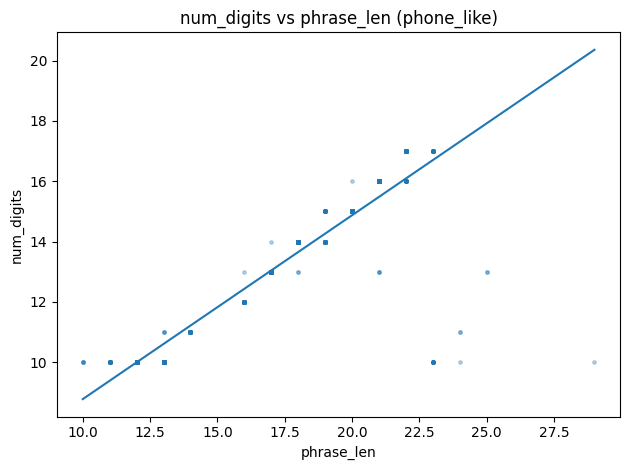

word          pendiente≈0.000  intercepción≈0.00


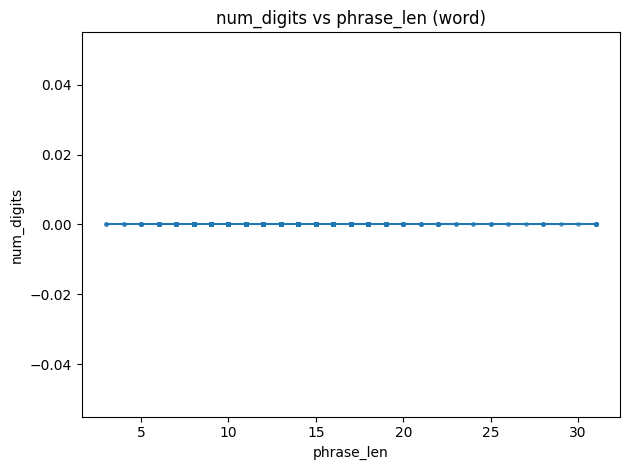

url           pendiente≈0.054  intercepción≈-0.64


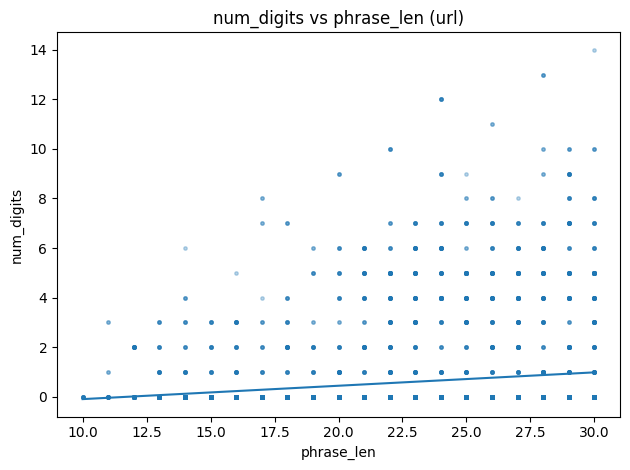

address_like  pendiente≈0.052  intercepción≈3.46


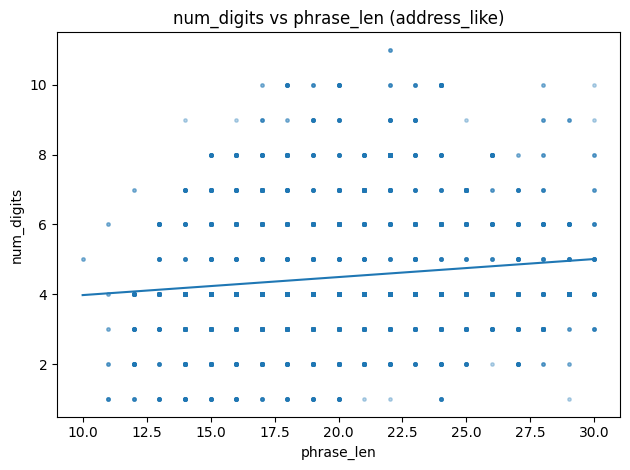

In [22]:
for t in train["phrase_type"].value_counts().index:
    df = train[train["phrase_type"]==t]
    if len(df) < 50: 
        continue
    x = df["phrase_len"].values
    y = df["num_digits"].values
    m, b = np.polyfit(x, y, 1)   # pendiente y ordenada
    print(f"{t:12s}  pendiente≈{m:.3f}  intercepción≈{b:.2f}")

    # Dispersión + recta
    plt.figure()
    plt.scatter(x, y, s=6, alpha=0.3)
    xline = np.linspace(x.min(), x.max(), 100)
    yline = m*xline + b
    plt.plot(xline, yline)
    plt.title(f"num_digits vs phrase_len ({t})")
    plt.xlabel("phrase_len"); plt.ylabel("num_digits")
    plt.tight_layout(); plt.show()


- phone_like: pendiente positiva alta (más dígitos conforme crece la longitud).
- url: pendiente positiva baja (URLs largas agregan dígitos, pero menos que phone_like)
- word: pendiente ~ 0 (sin dígitos).
- mixed: pendiente leve (mezcla letras/dígitos).
- Uso: features de interacción como num_digits / phrase_len o num_symbols / phrase_len ayudan a separar url/phone_like de word